# **Biometric challenge: Can you make your way into Cannes Festival?**

**Spring 2023, 
Course: Imaging for Security Applications**

**J.-L. Dugelay, N. Mirabet-Herranz**

**Student(s) name:** Julie Elisabeth Schult


Welcome to Côte d'Azur! 
As you may know, one of the most important events of the region is the well known *Cannes Film Festival*. You want to have access to it to meet the most popular celebrities of the decade but there is a problem, the festival is secured with a face biometrics system!

As an Eurecom student you have access to some imaging security knowledge and it appears to be in your possesion the face recognition system that is being used. Your objective is to evaluate the system to know more about how it operates and to adapt a  “hacking” technique to it.


**General instructions**

- Answer the questions precisely. Remember you should provide your comments and justifications for each step of the challenge. You will find a text cell after each question with **"Your answer"** marked.

- Send the complete notebook with your answers (in English) before **April 6th**. 

- Remember to indicate your name & surname at the beginning of the notebook.

-  The code of the notebook has to run. If it presents compilation errors the student will be asked to submit a new running version and will be penalized.

**Challenge description**

- This challenge will focus on face recognition and morphing. We will work with a pre-trained Vgg-Face model architecture, the dlib cnn face detector and a face morphing function.

- We will work with a self-collected Eurecom database consisting of 400 images of 20 individuals (different gender, age and ethnicity). Each image has a different size and there are variations in illumination, pose, facial expressions…

- The name of face images is of the form: name_??.jpg where "name" is  the surname of the subject and ?? a number between #1 and #20 that identifies each variation of the same individual. *Example: murphy_01.jpg / aniston_15.jpg*

# **0. Setting up the lab**

### **0.1. Installation (conda, environment)**

In [1]:
!which conda

/usr/local/bin/conda


If it is not installed, let's do it together!


In [2]:
# try to install miniconda
conda_path = ''
try:
    conda_path = !which conda
finally:
    print('')

if (len(conda_path) == 0):
    print('installing miniconda')
    !wget https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh && bash Miniconda3-4.5.4-Linux-x86_64.sh -bfp /usr/local
    !conda update conda -y -q
    !source /usr/local/etc/profile.d/conda.sh
    !conda init 
    !conda install -n root _license -y -q
else:
    print('found miniconda')


found miniconda


Let's check if it was correctly installed.

In [3]:
!which conda

/usr/local/bin/conda


Now, let's set up a conda environment for our mission. We need to create a new environment, let's call it "BiometricChallenge". Then, we need to install the packages we will be needing.

In [4]:
conda_envs = !conda env list
res = [i for i in conda_envs if 'BiometricChallenge' in i]
if (len(res) == 0):
    print('not found BiometricChallenge env', len(res))
    !conda create -y -q --name BiometricChallenge python=3.6 tensorflow
else:
    print('found BiometricChallenge env', len(res))

found BiometricChallenge env 1


In [5]:
%%bash
conda env list
source activate BiometricChallenge


# conda environments:
#
base                     /usr/local
BiometricChallenge       /usr/local/envs/BiometricChallenge



To enable GPU, go to the Toolbar > RunTime > Change runtime type > Set Hardware Accelerator > GPU

### **0.2. Data preparation**



1.   Download the 'BiometricChallenge.zip' file from moodle and extract it.  In this compressed fodler, may find the weights of the pretrained models that you need for this challenge, and the data that you need to evaluate the face recognition system used by the Cannes Festival.
2.   Upload the extracted folder 'BiometricChallenge' to your Google Drive under >MyDrive.
3.   Mount yout Google Drive by running the following cell and following the steps that are proposed.


In [6]:
from google.colab import drive

drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


Verify that your Google drive was mounted correctly, and that the data is in the right path.

In [7]:
# Add your path here:
!ls /gdrive/MyDrive/BiometricChallenge/

2023_Biometric_Challenge_Schult.ipynb
Biometric_challenge_instructions.pdf
face_classifier_model_cannes_array_new.h5
mmod_human_face_detector.dat
morph.py
__pycache__
selfie1.jpeg
selfie2.jpeg
selfie3.JPG
shape_predictor_68_face_landmarks.dat
testset
vgg_face_weights.h5


# **1. Verification of a Face Classifier**



A facial recognition system is a technology capable of matching a human face from a digital image or a video frame against a database of faces, typically employed to authenticate users through ID verification services. It works by pinpointing and measuring facial features from a given image.

In this challenge, face recognition is achieved using a Deep Learning method that is Convolutional Neural Network (CNN). A CNN is a multi-layer network trained to perform a specific task using classification. 

In this section we will obtain verification results; verification answers to the question “Is he/she the person he/she claims to be?”

We split this database into three image sets for the face classification model: Train-Validation-Test. 14 images from each subject were used for training, 4 for validation and 2 remain for testing. 

**Therefore the images to use in the test part are of the form:** name_??.jpg where "name" is  the surname of the subject and ?? a number between **#19** and **#20** that identifies each variation of the same individual not used in the training process. *Example: watson_19.jpg / wood_20.jpg*


### **1.0. Tools preparation**

#### **1.0.1. Import all the needed packages**

In [8]:
# We set our path
path="/gdrive/MyDrive/BiometricChallenge/"

# First of all we import the packages

# General
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn import metrics

# C++ and OpenCV
import dlib
import cv2

# CNN
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import ZeroPadding2D,Convolution2D,MaxPooling2D
from tensorflow.keras.layers import Dense,Dropout,Softmax,Flatten,Activation,BatchNormalization
from tensorflow.keras.preprocessing.image import load_img,img_to_array
#from keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input
import tensorflow.keras.backend as K

#### **1.0.2. Load the pre-trained networks**

In [9]:
# Load the face detector from the dlib package
dnnFaceDetector=dlib.cnn_face_detection_model_v1(path+"mmod_human_face_detector.dat")

# Load pre-trained VGG model
classifier_model=tf.keras.models.load_model(path+'face_classifier_model_cannes_array_new.h5')

# Path to folder which contains images to be tested and predicted
test_images_path=path+'testset/'

In [10]:
#Define VGG_FACE_MODEL embeddings
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))
model.load_weights(path+'vgg_face_weights.h5')
model.summary()
vgg_face=Model(inputs=model.layers[0].input,outputs=model.layers[-2].output)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 226, 226, 3)      0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 226, 226, 64)     0         
 ng2D)                                                           
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                        

#### **1.0.3. Some useful functions**

In [12]:
# display an image given as an input
def plot(img):
    plt.figure(figsize=(8,4))
    plt.imshow(img[:,:,::-1])
    plt.show()


# Names label for class numbers
person_rep={0: 'streep',
 1: 'blanchet',
 2: 'murphy',
 3: 'schwarzenegger',
 4: 'aniston',
 5: 'hathaway',
 6: 'chan',
 7: 'zendaya',
 8: 'reeves',
 9: 'portman',
 10: 'hutcherson',
 11: 'butler',
 12: 'winfrey',
 13: 'watson',
 14: 'wood',
 15: 'washington',
 16: 'goldberg',
 17: 'stallone',
 18: 'firth',
 19: 'liu'}

### **1.1. Define the function similarity score prediction**

- Follow the comments in the code.

- Display some of the cropped faces. Did you compute your coordinates (width and height) correctly? If so move to the next step. 

**Warning: For displaying use the function defined in 1.0.3 plot()**

In [39]:
def predict_scores(input_image):


  #First, detect the face
  #convert the image into grayscale as the face detector only works on grayscale images

  # using the cvtColor() method
  img_gray = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)

  #now use the face detector dnnFaceDetector

  rect = dnnFaceDetector(img_gray)
  rect = rect[0]

  #the dnnFaceDetector generates a list of rectangles, this length of this list can be >1 if there are more than one face in the imae
  #Normally we only have one face per image, so we consider only the first rectangle in the list (rect=rects[0]). However if this is not the case for some images errors can be caused.

  left,top,right,bottom=0,0,0,0
  # Coordinates to crop the image to the detected face
  left=rect.rect.left() #x1
  top=rect.rect.top() #y1
  right=rect.rect.right() #x2
  bottom=rect.rect.bottom() #y2
  width= right - left
  height= bottom - top

  #Crop the image using the previous coordinates

  image_crop = input_image[left:right, top:bottom]

  #Resize the cropped image to 224x224 pixels, as the pretrained VGGFace model can only take images of 224x224 pixels

  image_crop = cv2.resize(image_crop, (224,224), interpolation = cv2.INTER_AREA)

  #Preprocessing of the (resized cropped) image so it can be fed to the pretrained VGGFace model
  image_crop=np.expand_dims(image_crop,axis=0)
  image_crop=preprocess_input(image_crop)

  #Extraction of the VGGFace embedding from the preprocessed image 
  embedding=vgg_face(image_crop)

  #Predict the similarity score from the VGGFace embedding using the pretrained classifier model  'classifier_model'

  pred_scores = classifier_model(embedding)
            
  return pred_scores

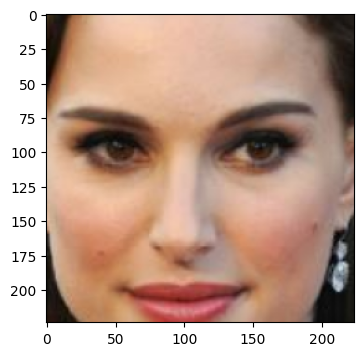

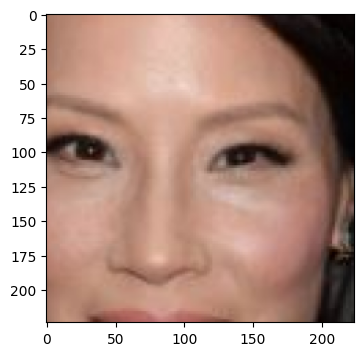

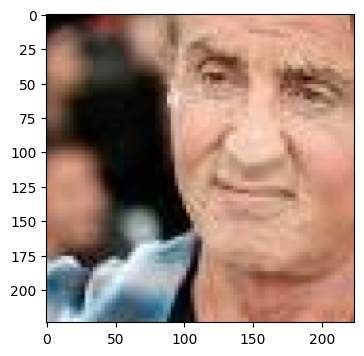

In [17]:
# Display some of the cropped faces
img_list = ['portman_19.JPG' ,'liu_20.JPG', 'stallone_19.JPG']
for i in img_list:
  img = cv2.imread(test_images_path+i)
  
  # Using parts of the code written above
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  rect = dnnFaceDetector(img_gray)
  rect = rect[0]

  left,top,right,bottom=0,0,0,0
  left=rect.rect.left()
  top=rect.rect.top()
  right=rect.rect.right()
  bottom=rect.rect.bottom()
  width= right - left
  height= bottom - top

  image_crop = img[left:right, top:bottom]
  image_crop = cv2.resize(image_crop, (224,224), interpolation = cv2.INTER_AREA)

  plot(image_crop)

### **1.2. Compute the predictions of 3 celebrities of your choice.**

-  Are they correctly classified?

-  Comment on the scores

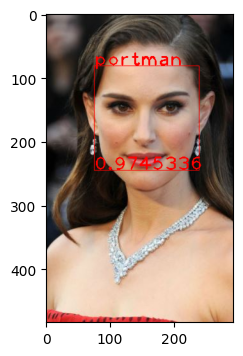

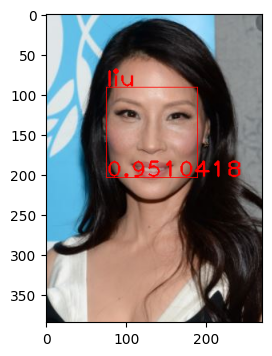

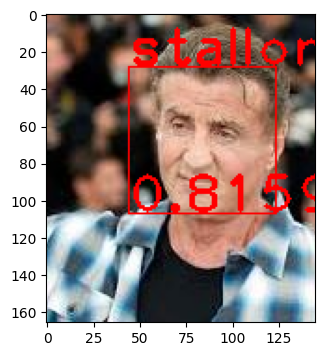

In [41]:
test_list=['portman_19.JPG' ,'liu_20.JPG', 'stallone_19.JPG'] # Pick 3 celebrities of your choice, insert the filename e.g test_list=['portman_19.JPG' ,'liu_20.JPG', 'stallone_19.JPG']

# Now we obtain the predictions for every person in the test set
for img_name in test_list:

  #Load the image

  img = cv2.imread(test_images_path+img_name)

  #Predict the similarity scores 

  predicted_scores = predict_scores(img)

  #Definition the predicted identity (name)
  name=person_rep[np.argmax(predicted_scores)]

  #Now, let's display the celebrity images with all the predicted information
  #Let's show the face bounding box, to do so we follow the steps in the previous subsection 1.1:
  #Convert the image into grayscale, use dnnFaceDetector and define the cordinates x1, y1, x2, y2, width and height

  ## Using parts of the code in the predict_scores() function
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  rect = dnnFaceDetector(img_gray)
  rect = rect[0]

  left,top,right,bottom=0,0,0,0
  left=rect.rect.left() #x1
  top=rect.rect.top() #y1
  right=rect.rect.right() #x2
  bottom=rect.rect.bottom() #y2
  width= right - left
  height= bottom - top

  #Draw the face bownding box, you can use the method cv2.rectangle(image, start_point, end_point, color, thickness)

  cv2.rectangle(img, (left, top), (right, bottom), (0, 0, 255), 1) # color red and thickness 1

  #Display the name of the predicted identity on the top (or the bottom) of the bounding box, you can use the method cv2.putText(image, text, position, font, fontScale, color, thickness, lineType)

  cv2.putText(img, name, (left, top), cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 2, cv2.LINE_8)

  #Display the predicted similarity score of that corresponds to the predicted identity on the bottom (or the top) of the bounding box, you can use the method cv2.putText(image, text, position, font, fontScale, color, thickness, lineType)

  score = str(np.max(predicted_scores)) #predicted similarity score
  cv2.putText(img, score, (left, bottom), cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 2, cv2.LINE_8)

  #Display the celebrity images with all the predicted information

  plot(img)


**Your Comments on the scores:** 

Portman: 0.914

Liu: 0.951

Stallone: 0.815

We can see that Lui got the highest score, while Stallone got the lowest. This is due to the angle of the face. Lui is looking straight at the camera, while Stallone is looking away. 


### **1.3. Genuine/Impostor similarity score distribution**



#### **1.3.1 Compute the genuine and the imposter similarity scores**

*   Genuine score: are the similarity scores of comparing pairs of images belonging to the same identity (i.e. the same person).
*   Imposter scores: are the similarity scores of comparing pairs of images belonging to different identities (i.e. different people.

If the face recognition systems works correctly, genuine similarity scores are supposed to be high, and the imposter similarity scores are supposed to be low.

In [20]:
# Complete the following code:

genuine_scores=[]
imposter_scores=[]
for filename in sorted(os.listdir(test_images_path)):
  image=cv2.imread(test_images_path+filename)
  genuine_name = filename.split('_')[0]

  pred_scores = predict_scores(image)
  print(pred_scores[0], np.shape(pred_scores)[1])
  for i in range(np.shape(pred_scores)[1]) :
    if person_rep[i] == genuine_name :
      genuine_scores.append(pred_scores[0][i])
    else :
      imposter_scores.append(pred_scores[0][i])

# Since there are 20 subjects each of them with 2 images, you will have a vector with 40 genuine scores and a vector with 760 imposter scores

tf.Tensor(
[0.00073774 0.01591532 0.02013801 0.01263386 0.5863703  0.00297266
 0.02674361 0.00553101 0.0136947  0.05077692 0.00338254 0.06491164
 0.00090627 0.01331541 0.02504426 0.01263757 0.00969443 0.02229644
 0.00504132 0.10725594], shape=(20,), dtype=float32) 20
tf.Tensor(
[6.5839587e-05 3.2249975e-03 1.8555243e-02 4.1090650e-03 8.9121759e-01
 3.6214694e-04 5.5737873e-03 1.5445431e-03 6.5525235e-03 8.9799082e-03
 7.5703545e-04 6.1185285e-03 1.2770888e-03 1.3750433e-02 6.2035359e-03
 1.4111757e-02 3.4643186e-03 7.2919959e-03 1.2287237e-03 5.6110350e-03], shape=(20,), dtype=float32) 20
tf.Tensor(
[0.01504637 0.02374637 0.07081123 0.25355074 0.0621534  0.02642415
 0.02600691 0.03685036 0.04302224 0.02504606 0.01085094 0.20528935
 0.01018045 0.02543757 0.0346962  0.0403694  0.02270095 0.00867082
 0.00891534 0.05023111], shape=(20,), dtype=float32) 20
tf.Tensor(
[4.1136509e-03 9.4102180e-01 7.5124600e-03 9.9448871e-04 8.9445192e-04
 7.6534801e-05 4.8352350e-03 2.4191062e-04 7.5082052e-

#### **1.3.2 Plot genuine and impostor scores distributions**

- Plot in **the same** plot both the histogram of the genuine and the impostor scores.

- Fit a gaussian to each distribution.

- Comment the plot



**Your Comments:** 

The mean of the imposter scores are close to zero, and most of the values are low. The mean of the genuine scores are more spread over the whole interval. A result like this can implify that we can have false negative detections. 

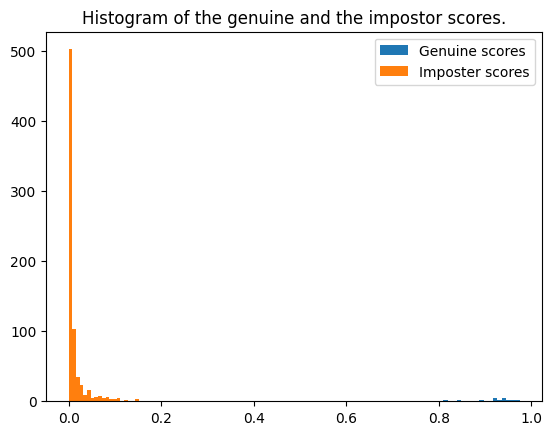

In [21]:
# Plot in the same image the histogram of the genuine and the impostor scores(each with a different color) 

plt.hist(genuine_scores, bins = 100, label = 'Genuine scores')
plt.hist(imposter_scores, bins = 100, label = 'Imposter scores')
plt.title('Histogram of the genuine and the impostor scores.')
plt.legend()
plt.show()

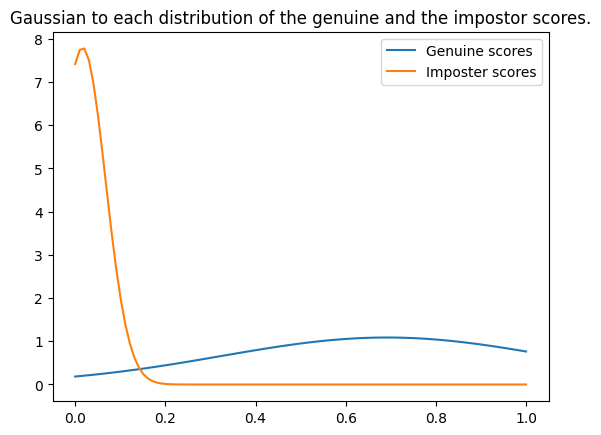

In [22]:
mean_g, std_g = norm.fit(genuine_scores)
mean_i,std_i = norm.fit(imposter_scores)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y_g = norm.pdf(x, mean_g,std_g)
y_i = norm.pdf(x, mean_i,std_i)

plt.title('Gaussian to each distribution of the genuine and the impostor scores.')
plt.plot(x, y_g, label = 'Genuine scores')
plt.plot(x, y_i, label = 'Imposter scores')
plt.legend()
plt.show()

### **1.4. Plot the Receiver Operating Characteristic (ROC) curve**

- Comment the plot


**Your Comments:**

In the plot of the ROC, we can see that near 0 we cover 80% of the samples. As we also saw in the 2 previous plots are these samples true positives. 

At around x=0.4 we cover approximately all of the samples.

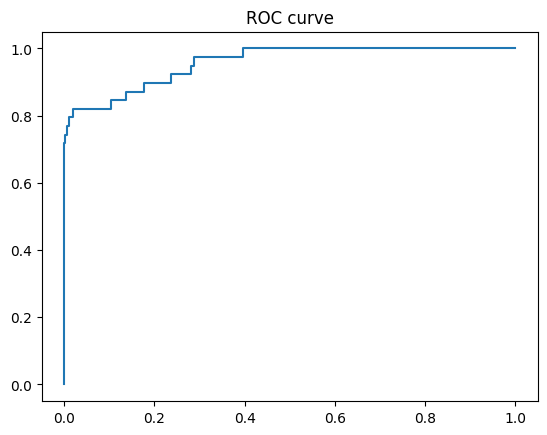

In [23]:
# You can use an existing function like sklearn.metrics.roc_curve

zero = np.zeros(len(imposter_scores))
one = np.ones(len(genuine_scores))

true = np.concatenate((zero, one))
score = np.concatenate((imposter_scores, genuine_scores))

x, y, t = metrics.roc_curve(true, score)

plt.title('ROC curve')
plt.plot(x,y)
plt.show()

### **1.5. Deduce the score threshold**

- Define a face verification function, verification answers to the question “Is he/she the person he/she claims to be?”. So the face_verification function will take as input an identity (name) and a face image (input_image) and returns a message that says if the person is in the guest list or not. In this function, you have to define a similarity score threshold deduced from the previous plots.
- If the similarity score of the image given as an input with the class of the person of which the identity is given as input is **lower than the threshold**, than the request to access the Cannes Festival will be rejected and the face_verification function will return the following message "Sorry! your name is not on the guest list for the Cannes Festival!".

- If the similarity score of the image given as an input with the class of the person of which the identity is given as input is **higher than the threshold**, than the request to access the Cannes Festival will be accepted and the face_verification function will return the following message "Welcome,", <name>, ", to the Cannes festival!".

**Question:** What happens if we lower or increase the threshold? For which application can we use a lower/higher threshold? What are the consequences?


**Your Answer to the Question:**

With a low threshold we get more false positives, while with a high threshold we get more false negatives.

In [24]:
# Complete the following code: 
def face_verification(name, input_image):
  #First define the similarity score threshold

  threshold= 0.7
  
  #Then generate the prediction scores of the image input_image

  pred_score = predict_scores(input_image)

  #Finally, develop the face verification step 

  name0 = person_rep[np.argmax(pred_score)] #Definition the predicted identity (name)
  max_score = np.max(pred_score)

  if (name == name0 and max_score >= threshold):
    print('Welcome, '+ name.capitalize() + ', to the Cannes festival!')
    return
  print('Sorry, '+ name.capitalize() + ' is not in the invitation list to the Cannes festival!')

Perform the face verification experiment on all the images in the testset, for a celebrity of your choice.

In [25]:
for filename in sorted(os.listdir(test_images_path)):
  image=cv2.imread(test_images_path+filename)
  face_verification('chan', image) # Check for a celebrity of your choice

Sorry, Chan is not in the invitation list to the Cannes festival!
Sorry, Chan is not in the invitation list to the Cannes festival!
Sorry, Chan is not in the invitation list to the Cannes festival!
Sorry, Chan is not in the invitation list to the Cannes festival!
Sorry, Chan is not in the invitation list to the Cannes festival!
Sorry, Chan is not in the invitation list to the Cannes festival!
Welcome, Chan, to the Cannes festival!
Welcome, Chan, to the Cannes festival!
Sorry, Chan is not in the invitation list to the Cannes festival!
Sorry, Chan is not in the invitation list to the Cannes festival!
Sorry, Chan is not in the invitation list to the Cannes festival!
Sorry, Chan is not in the invitation list to the Cannes festival!
Sorry, Chan is not in the invitation list to the Cannes festival!
Sorry, Chan is not in the invitation list to the Cannes festival!
Sorry, Chan is not in the invitation list to the Cannes festival!
Sorry, Chan is not in the invitation list to the Cannes festival

# **2. Face morphing attack**

A morphed face image is a synthetically created image that looks so similar to the faces of two subjects that both can use it for verification against a biometric verification system. 

In this section of the challenge, we will use this technique to modify your picture and generate a new image that will be succesfully classified as one celebrity in the dataset but that visually will also look as yourself. 

### **2.0. Tools preparation** 


Import the face processing functions needed for creating the morphing attack.

In [26]:
import sys  
sys.path.insert(0, path)
from morph import load_image_points, weighted_average_points, warp_image, mask_from_points, weighted_average, overlay_image

Load the facial landmark detector (68 points). The facial landmarks will be later used to align the 2 images used for the morphing attack.


In [27]:
dlib_predictor = dlib.shape_predictor('/gdrive/MyDrive/BiometricChallenge/shape_predictor_68_face_landmarks.dat')

### **2.1. Define the morphing attack function**



Define morph_face function that takes as an input a source image, a target image and a weight value between 0 and 1 and it returns a morphed face.

Here a description of all the functions (imported in 2.0.) that you need for the face morphing.

 

*   load_image_points(img, size, dlib_predictor ): Locates 68 face points using dlib shape predictor and then it resizes image and associated points, align the face to the center and crop to the desired size. The function returns 2 outputs: the aligned, cropped and resize image and the 68 facial landmark points.
*   weighted_average_points(start_points, end_points, percent=0.5) : it returns a weighted average of two sets of supplied points.
*   warp_image(src_img, src_points, dest_points, size, dtype=np.uint8): it warps each triangle from the src_image only within the region of interest ROI of the destination image (points in dst_points). The function returns the warped image of the supplied size.
*   mask_from_points(size, points): it creates and returns a mask of supplied size from  points.
*   weighted_average(img1, img2, percent=0.5): it returns an image that is a weighted average of the two images given as input.
*   overlay_image(foreground_image, mask, background_image): it overlays foreground image onto the background given a mask and returns the resulting image.








In [28]:
# Complete the following code:

def morph_face(src_img, dest_img, percent):
  size=(600,500)

  #First, we detect the 68 facial landmark points, we align, crop and resize the two images
  #The source image is your picture
  #The destination image is the image of the celebrity that you will be stealing his identity
  
  src_crop, src_points = load_image_points(src_img, size, dlib_predictor)
  dest_crop, dest_points = load_image_points(dest_img, size, dlib_predictor)

  #Next, we compute the weighted average of the two sets of 68 facial landmarks
 
  points = weighted_average_points(src_points, dest_points, percent)

  #Then, we warp the two images according to the weighted average of the two sets of the 68 facial landmarks

  src_face = warp_image(src_crop, src_points, points, size, dtype=np.uint8)
  dest_face = warp_image(dest_crop, src_points, points, size, dtype=np.uint8)
  
  #To get the morphed face, we compute the weighted average of the two warped images

  average_face = weighted_average(src_face, dest_face, percent)

  #To give the morphed image more credibility, we also compute the weighted average of the background
 
  average_background = weighted_average(src_crop, dest_crop, percent)

  #We define the mask in which the morphed face will be placed, and that's according to the weighted average of the two sets of the 68 facial landmarks
  
  mask = mask_from_points(size, points)

  #Finally, we overlay the morphed face and the wieghted average background to get the final picture
  
  average_face = overlay_image(average_face, mask, average_background)

  return average_face

### **2.2. Preparation of your face image**

Take a picture of yourself, using your cellphone (easiest option) or a camera, and upload it on your google drive under the following path: /gdrive/MyDrive/BiometricChallenge/. Verify if you uploaded your picture in the right folder.


In [45]:
!ls /gdrive/MyDrive/BiometricChallenge/

2023_Biometric_Challenge_Schult.ipynb
Biometric_challenge_instructions.pdf
face_classifier_model_cannes_array_new.h5
mmod_human_face_detector.dat
morph.py
__pycache__
selfie1.jpeg
selfie2.jpeg
selfie3.JPG
selfie4.jpg
shape_predictor_68_face_landmarks.dat
testset
vgg_face_weights.h5


### **2.3. Perform the morphing attack**
- Generate a morphing attack using 50% of your face image and 50% of a face image of a celebrity. For this you need to follow some steps:

### **2.3.1 First morphing attack attempt**

1. Get the similarity scores with all the celebrities (20) that are enrolled, who do you look like the most?

2.  Morph your face with the selected celebrity (50%-50%)

3. And apply the face_verification() function to the morphed image.

**N.B.:** In Step 1, in addition to the scores suggestion, try to pick a celebrity with the same gender and ethnicity as you.

**N.B.:** if you get a memory error, it might be due to the big size of your face image, try to sample it down, using cv2.resize. 


In [46]:
# Step 1

#First, load your image and resize it to (256,256)

src_image = cv2.imread('/gdrive/MyDrive/BiometricChallenge/selfie4.jpg') # My image
#src_image = cv2.resize(src_image, (256,256), interpolation = cv2.INTER_AREA)

#Then, generate the predicted similarity scores to all the 20 celebrities.

myscores=predict_scores(src_image)

#Finally, check which of the celebrities looks the most like you (i.e. with which you have the highest similarity score)

chosen = person_rep[np.argmax(myscores)]
print(chosen)

aniston


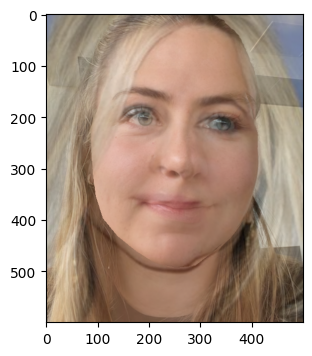

In [48]:
# Step 2

src_image = cv2.imread( '/gdrive/MyDrive/BiometricChallenge/selfie4.jpg' ) #my face image
dest_image = cv2.imread( test_images_path + 'aniston_20.JPG')# the face image of the celebrity

# First try with 50% morphed face
morph50 = morph_face(src_image, dest_image, 0.5)

# Plot the morphed image 
plot(morph50)

In [49]:
# Step 3
face_verification('aniston', morph50)


Welcome, Aniston, to the Cannes festival!


### **2.3.2 Explore different morphing tresholds**

4. Generate various morphed faces (100) depending on the weight given to each of the identities (your identity, and the identity of the celebrity that you look like the most). You can also plot the morphed images at each iteration to validate your code.

5.  Plot the similarity score for each of the (100) morphed faces.

6. Pick the morphed image that gives a similarity score that is over the threshold (defined in the previous section) and looks the most like you. Comment on the plot and the image selected.

7. Test the face verification function with the morphed image. What is the similarity score that you obtained?

**N.B.:** In step 6, once the morphed image is selected, specify in your answer the weight assigned to your face image, and the weighted assigned to the celebrity's face image, as well as the similarity score obtained by comparing the selected morphed image to the class of the target celebrity.


In [50]:
# Step 4

# Complete the following code:
src_image = cv2.imread( '/gdrive/MyDrive/BiometricChallenge/selfie4.jpg') # My image
dest_image_alike = cv2.imread( test_images_path + 'aniston_20.JPG' ) #the image of the celebrity that you look like the most
scores_morph_alike = []

for percent in np.linspace(0, 1,101):
  # Generate the morphed face accroding to the percentage
  print(percent)
  morphed = morph_face(src_image, dest_image_alike, percent)

  # Predict the similarity score to the selected celebrity
  pred_scores = predict_scores(morphed)
  pred_scores = pred_scores[0][4]

  # Append the obtained similarity score to the list 'scores_morph_alike' 

  scores_morph_alike.append(pred_scores)
  plot(morphed)
  

Output hidden; open in https://colab.research.google.com to view.

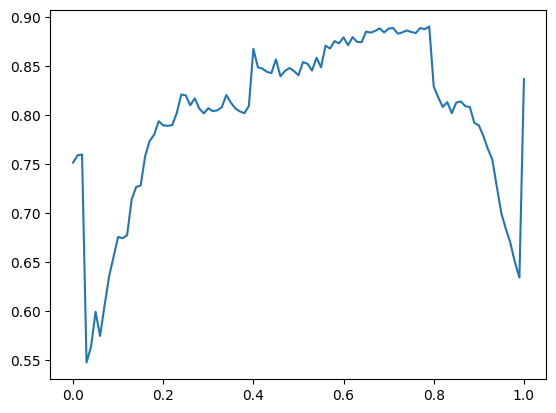

In [51]:
# Step 5

x = np.linspace(0, 1, 101)
plt.plot(x, scores_morph_alike)
plt.show()

The best percentage for morph is:  0.79


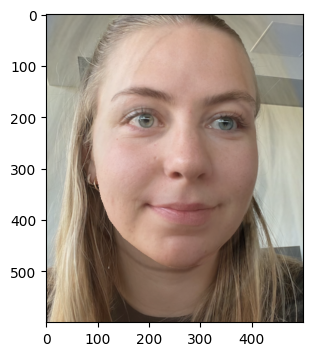

In [55]:
# Step 6

max_index = scores_morph_alike.index(max(scores_morph_alike))
print('The best percentage for morph is: ', (max_index/100))
morphed = morph_face(src_image, dest_image_alike, (max_index/100))
plot(morphed)

In [60]:
# Step 7
pred_score = predict_scores(morphed)
pred_score = pred_score[0][4]

print('The similarity score for 79% is ', float(pred_score))

The similarity score for 79% is  0.8906986713409424


**Your Comments:** I have here used the Jennifer Aniston as the celebrity I look the most like. When running through all the percetages (0.1 to 1), we can firstly see that the similarity scores are low for low and high percentages. After around 0.05%, the score increases to 79% where we find the maximum score. The lowest score was of 55%, at around 5%.

We can see here that there are some similarities between these 2 pictures, with respect to skin color and the angle of the photo. But there are also some differences, where we get a low similarity score. This can for example be because of how the hair is.

### **2.4. Test more the classifier.**

For this experiment, pick a cross-gender/cross-ethnicity celebrity of your choice. Choose a celebrity that doesn't have the same gender AND the same ethnicity as you.

8. Generate various morphed faces (100) depending on the weight given to each of the identities (your identity, and the identity of the cross-gender/cross-ethnicity celebrity). You can also plot the morphed images at each iteration to validate your code.

9.  Plot the similarity score for each of the (100) morphed faces.

10. Pick the morphed image that gives the highest similarity score (if possible over the threshold) and looks the most like you. Comment on the plot and the image selected.

11. Test the face verification function with the morphed image. Comment on the similarity score that you obtained.



In [62]:
# Step 8

src_image = cv2.imread( '/gdrive/MyDrive/BiometricChallenge/selfie4.jpg') # My image
dest_image_alike = cv2.imread( test_images_path + 'murphy_19.JPG' ) #the image of the celebrity that you look like the most
scores_morph_alike = []

for percent in np.linspace(0, 1,101):
  # Generate the morphed face accroding to the percentage
  print(percent)
  morphed = morph_face(src_image, dest_image_alike, percent)

  # Predict the similarity score to the selected celebrity
  pred_scores = predict_scores(morphed)
  pred_scores = pred_scores[0][4]

  # Append the obtained similarity score to the list 'scores_morph_alike' 

  scores_morph_alike.append(pred_scores)
  plot(morphed)

Output hidden; open in https://colab.research.google.com to view.

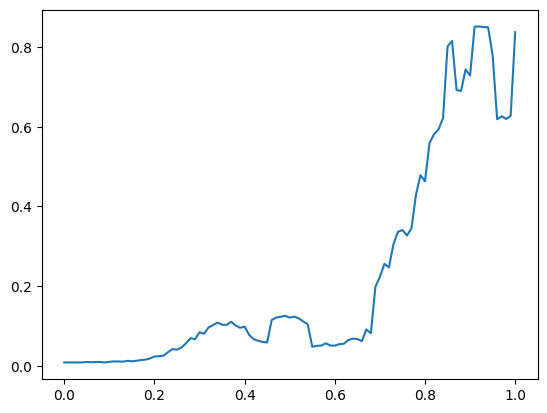

In [63]:
# Step 9

x = np.linspace(0, 1, 101)
plt.plot(x, scores_morph_alike)
plt.show()

The best percentage for morph is:  0.92


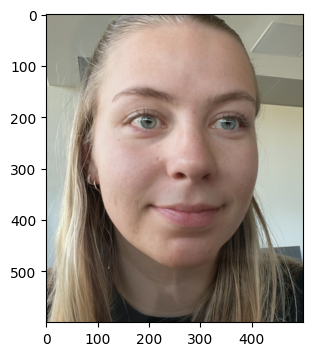

In [64]:
# Step 10

max_index = scores_morph_alike.index(max(scores_morph_alike))
print('The best percentage for morph is: ', (max_index/100))
morphed = morph_face(src_image, dest_image_alike, (max_index/100))
plot(morphed)

In [66]:
# Step 11

pred_score = predict_scores(morphed)
pred_score = pred_score[0][4]

print('The similarity score for 92% is ', float(pred_score))

The similarity score for 92% is  0.8513597846031189


**Your comments:**
Here I have morphed myself with someone of a differend gender and ethnisity. In the graph we can see that with a low percentage, the similarity is around 0. As the percentage increases, so does the similarity. Over all the 100 similarities, we have the highest at 92% with a similarity of 0.85%.

There are differences between my picture and Eddie Murphy's picture, which makes the similarities overall much smaller.

- **Question:** Compare this plot to the one generated in the previous section 2.3.2. What do you observe?

**Your answer:**

### **2.5. Select the final morphing attack image that looks most like you but will grant you access to the Cannes Festival.**

Now that you know all the tricks, the time has come!

Let's see the celebrity instead of which you will be attending the Cannes Festival.

We hope that you don't face any legal charges ;)


In [67]:
# Complete the following code:
src_image = cv2.imread( '/gdrive/MyDrive/BiometricChallenge/selfie4.jpg')
dest_image_alike = cv2.imread( test_images_path + 'aniston_20.JPG' )

final_morphed_face = morph_face(src_image, dest_image_alike, 0.79)
face_verification( 'aniston', final_morphed_face)

Welcome, Aniston, to the Cannes festival!


### **2.6. (Bonus question) Towards a more visually reliable image**

In previous exercises, the morphed image background was taken by averaging the background of the source and destination image. Is there any modifications we can preform in order to visually improve the final morphed image background?

In [ ]:
            #HERE YOUR CODE#

**Your answer:**

## **3- Save and submit your work**
Make sure you used Save on the notebook before downloading it. You can do this either by clicking on Ctrl+S or Files-> save. Then download your notebook Files-> download .ipynb. Verify that the output of the cells are saved.

If yes, send us the notebook file (.ipynb upload in Moodle). If you have problems with the size, compress first the notebook in a .zip

If not, double-check the settings at "Settings" -> "Site" and make sure "New notebooks use private outputs (omit outputs when saving)" is disabled. Similarly, check also "Edit" -> "Notebook settings" and make sure "Omit code cell output when saving this notebook" is disabled. And redo the first step.
